## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid", font_scale=1.4)


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
len(fmnist_dataset_train)

60000

In [ ]:
len(fmnist_dataset_test)

10000

In [ ]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, int(input_shape / 2)),
            nn.ReLU(),
            nn.Linear(int(input_shape / 2), int(input_shape / 4)),
            nn.ReLU(),
            nn.Linear(int(input_shape / 4), int(input_shape / 8)),
            nn.ReLU(),
            nn.Linear(int(input_shape / 8), num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 392]         307,720
              ReLU-3                  [-1, 392]               0
            Linear-4                  [-1, 196]          77,028
              ReLU-5                  [-1, 196]               0
            Linear-6                   [-1, 98]          19,306
              ReLU-7                   [-1, 98]               0
            Linear-8                   [-1, 10]             990
Total params: 405,044
Trainable params: 405,044
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.55
Estimated Total Size (MB): 1.56
----------------------------------------------------------------


Your experiments come here:

In [ ]:
def training_loop(model, train_loader, val_loader, loss_func, opt, n_epochs):
  train_loss = []
  train_accuracy = []
  values_loss = []
  values_accuracy = []

  for epoch in range(n_epochs):
    train_loss_epoch = []
    train_accuracy_epoch = []
    values_loss_epoch = []
    values_accuracy_epoch = []

    model.train(True)
    for X_batch, y_batch in train_loader:
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)
      opt.zero_grad()
      predictions = model(X_batch)
      y_predict = torch.argmax(predictions, axis=1)
      train_accuracy_epoch.append(torch.sum(y_predict==y_batch).item() / len(y_batch))
      loss = loss_func(predictions, y_batch)
      loss.backward()
      opt.step()
      train_loss_epoch.append(loss.item())
    
    model.train(False)
    with torch.no_grad():
      for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        predictions = model(X_batch)
        loss = loss_func(predictions, y_batch)
        values_loss_epoch.append(loss.item())
        y_predict = torch.argmax(predictions, axis=1)
        values_accuracy_epoch.append(torch.sum(y_predict==y_batch).item() / len(y_batch))
    train_accuracy.append(np.mean(train_accuracy_epoch))
    train_loss.append(np.mean(train_loss_epoch))
    values_accuracy.append(np.mean(values_accuracy_epoch))
    values_loss.append(np.mean(values_loss_epoch))
  return train_accuracy, values_accuracy, train_loss, values_loss

In [ ]:
def print_details_training(train_accuracy, values_accuracy, train_loss, values_loss):
  print("==================================================")
  print(f" training loss in first iteration: {train_loss[0]:.6f}")
  print(f" validation loss in first iteration: {values_loss[0]:.6f}")
  print(f" training accuracy in first iteration: {train_accuracy[0]:.6f}")
  print(f" validation accuracy in first iteration: {values_accuracy[0]:.6f}")
  print("==================================================")
  print(f" training loss in last iteration: {train_loss[-1]:.6f}")
  print(f" validation loss in last iteration: {values_loss[-1]:.6f}")
  print(f" training accuracy in last iteration: {train_accuracy[-1]:.6f}")
  print(f" validation accuracy in last iteration: {values_accuracy[-1]:.6f}")
  print("==================================================")

In [ ]:
model = TinyNeuralNetwork().to(device)
n_epochs = 20
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here

In [ ]:
train_accuracy, values_accuracy, train_loss, values_loss = training_loop(model, train_loader, test_loader, loss_func, opt, n_epochs)
print_details_training(train_accuracy, values_accuracy, train_loss, values_loss)

 training loss in first iteration: 0.578662
 validation loss in first iteration: 0.443273
 training accuracy in first iteration: 0.789646
 validation accuracy in first iteration: 0.837598
 training loss in last iteration: 0.160475
 validation loss in last iteration: 0.373275
 training accuracy in last iteration: 0.938327
 validation accuracy in last iteration: 0.892773


In [ ]:
def plot_accuracy_and_loss(train_accuracy, values_accuracy, train_loss, values_loss):
  accuracies = [train_accuracy, values_accuracy]
  losses = [train_loss, values_loss]
  acc_losses = [accuracies, losses]
  title = ['Accuracy', 'Loss']
  for i in range(len(acc_losses)):
    plt.figure(figsize=(12, 7))
    plt.plot(acc_losses[i][0], label='train')
    plt.plot(acc_losses[i][1], label='validation')
    plt.legend(loc='best', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.title(title[i], fontsize=20)
    plt.show()

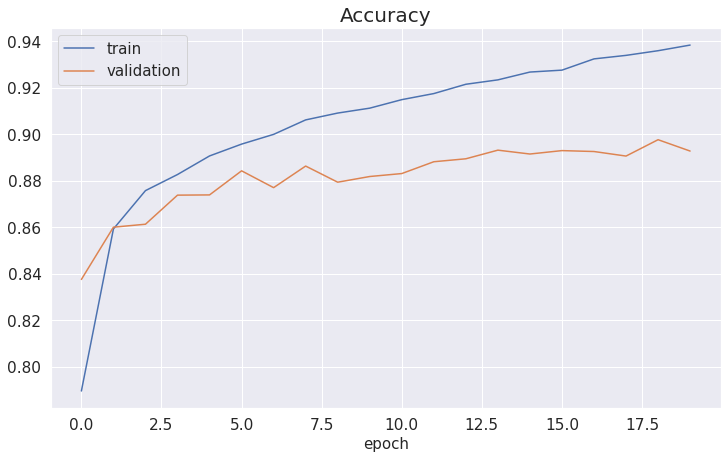

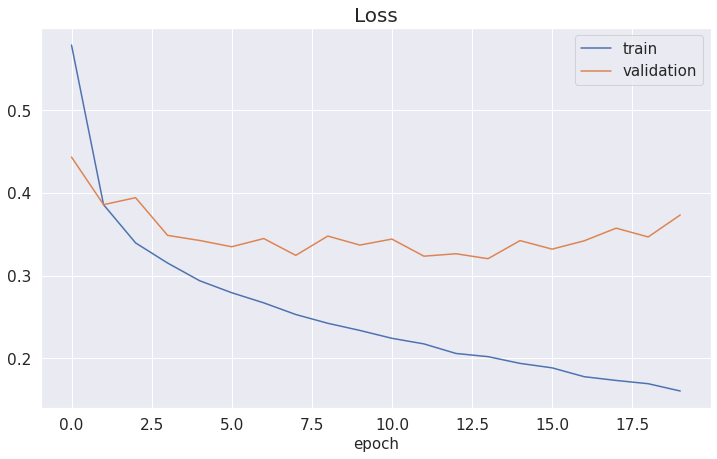

In [ ]:
plot_accuracy_and_loss(train_accuracy, values_accuracy, train_loss, values_loss)

In [ ]:
def print_testing_accuracy(model, test_loader):
  accuracy = []
  model.train(False)
  with torch.no_grad():
    for X_batch, y_batch in test_loader:
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)
      predictions = model(X_batch)
      y_predict = torch.argmax(predictions, axis=1)
      accuracy.append(torch.sum(y_predict==y_batch).item() / len(y_batch))
  print("Test accuracy is: ", np.mean(accuracy))

In [ ]:
print_testing_accuracy(model, test_loader)

Test accuracy is:  0.8927734375


**Conclusion:** I implemented a model consisting only of linear layers and activations, trained it for 20 epochs until the metric value on the test set reached 0.89. The graph for comparing the loss on the training and test sets shows overfitting even for a small architecture (8 layers, 405, 044 parameters): approximately in the middle of training, the loss on the validation set practically stops decreasing, while the loss on the training set continues to decrease monotonically.

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

Let's decrease the size of train dataset:

In [ ]:
indexes = np.arange(30000)
decreased_train_dataset = torch.utils.data.Subset(fmnist_dataset_train, indexes)
train_loader = torch.utils.data.DataLoader(decreased_train_dataset,
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=2)

In [ ]:
class OverfittingNeuralNetworkFirst(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape * 4),
            nn.ReLU(),
            nn.Linear(input_shape * 4, int(input_shape / 2)),
            nn.ReLU(),
            nn.Linear(int(input_shape / 2), int(input_shape / 4)),
            nn.ReLU(),
            nn.Linear(int(input_shape / 4), int(input_shape / 8)),
            nn.ReLU(),
            nn.Linear(int(input_shape / 8), int(input_shape / 16)),
            nn.ReLU(), 
            nn.Linear(int(input_shape / 16), num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetworkFirst().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 3136]       2,461,760
              ReLU-3                 [-1, 3136]               0
            Linear-4                  [-1, 392]       1,229,704
              ReLU-5                  [-1, 392]               0
            Linear-6                  [-1, 196]          77,028
              ReLU-7                  [-1, 196]               0
            Linear-8                   [-1, 98]          19,306
              ReLU-9                   [-1, 98]               0
           Linear-10                   [-1, 49]           4,851
             ReLU-11                   [-1, 49]               0
           Linear-12                   [-1, 10]             500
Total params: 3,793,149
Trainable params: 3,793,149
Non-trainable params: 0
---------------------------

In [ ]:
model = OverfittingNeuralNetworkFirst().to(device)
n_epochs = 50
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

In [ ]:
train_accuracy, values_accuracy, train_loss, values_loss = training_loop(model, train_loader, test_loader, loss_func, opt, n_epochs)
print_details_training(train_accuracy, values_accuracy, train_loss, values_loss)

 training loss in first iteration: 0.836245
 validation loss in first iteration: 0.607357
 training accuracy in first iteration: 0.690667
 validation accuracy in first iteration: 0.791016
 training loss in last iteration: 0.063572
 validation loss in last iteration: 0.599495
 training accuracy in last iteration: 0.975547
 validation accuracy in last iteration: 0.887207


Model with 12 layers and 3,793,149 trainable parameters: 

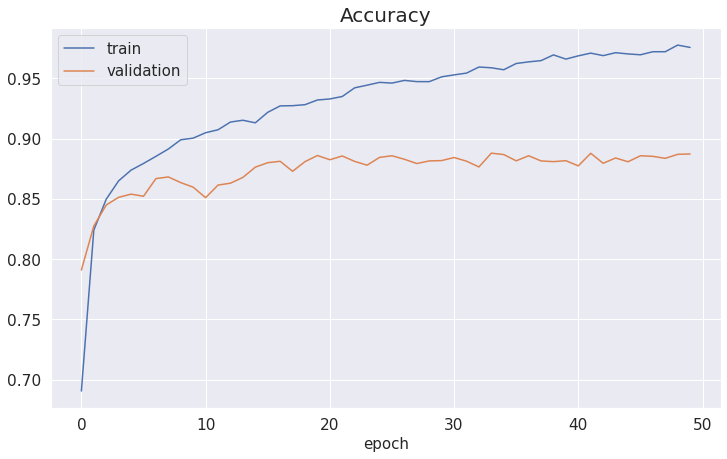

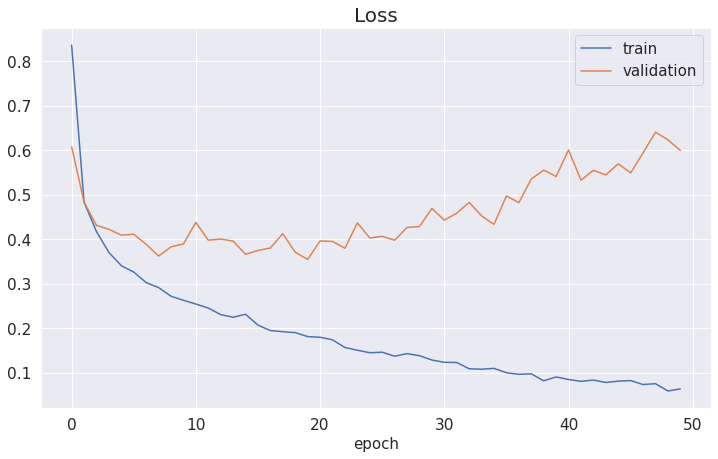

In [ ]:
plot_accuracy_and_loss(train_accuracy, values_accuracy, train_loss, values_loss)

In [ ]:
class OverfittingNeuralNetworkSecond(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape * 2),
            nn.ReLU(),
            nn.Linear(input_shape * 2, int(input_shape / 2)),
            nn.ReLU(),
            nn.Linear(int(input_shape / 2), int(input_shape / 4)),
            nn.ReLU(),
            nn.Linear(int(input_shape / 4), int(input_shape / 8)),
            nn.ReLU(),
            nn.Linear(int(input_shape / 8), int(input_shape / 16)),
            nn.ReLU(),
            nn.Linear(int(input_shape / 16), int(input_shape / 32)),
            nn.ReLU(),
            nn.Linear(int(input_shape / 32), num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetworkSecond().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
              ReLU-3                 [-1, 1568]               0
            Linear-4                  [-1, 392]         615,048
              ReLU-5                  [-1, 392]               0
            Linear-6                  [-1, 196]          77,028
              ReLU-7                  [-1, 196]               0
            Linear-8                   [-1, 98]          19,306
              ReLU-9                   [-1, 98]               0
           Linear-10                   [-1, 49]           4,851
             ReLU-11                   [-1, 49]               0
           Linear-12                   [-1, 24]           1,200
             ReLU-13                   [-1, 24]               0
           Linear-14                   

In [ ]:
model = OverfittingNeuralNetworkSecond().to(device)
n_epochs = 50
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

In [ ]:
train_accuracy, values_accuracy, train_loss, values_loss = training_loop(model, train_loader, test_loader, loss_func, opt, n_epochs)
print_details_training(train_accuracy, values_accuracy, train_loss, values_loss)

 training loss in first iteration: 1.127107
 validation loss in first iteration: 0.809650
 training accuracy in first iteration: 0.548166
 validation accuracy in first iteration: 0.690234
 training loss in last iteration: 0.079362
 validation loss in last iteration: 0.577151
 training accuracy in last iteration: 0.970505
 validation accuracy in last iteration: 0.882617


Model with 14 layers and 1,948,563 trainable parameters: 

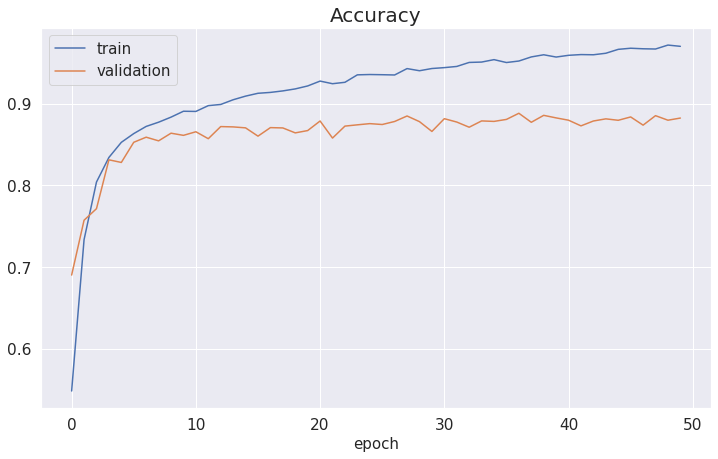

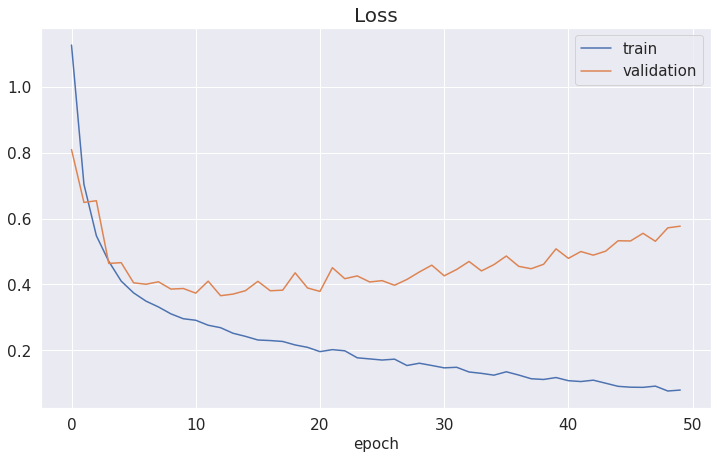

In [ ]:
plot_accuracy_and_loss(train_accuracy, values_accuracy, train_loss, values_loss)

In [ ]:
class OverfittingNeuralNetworkThird(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape * 2),
            nn.ReLU(),
            nn.Linear(input_shape * 2, int(input_shape / 2)),
            nn.ReLU(),
            nn.Linear(int(input_shape / 2), int(input_shape / 4)),
            nn.ReLU(),
            nn.Linear(int(input_shape / 4), int(input_shape / 8)),
            nn.ReLU(),
            nn.Linear(int(input_shape / 8), num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetworkThird().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
              ReLU-3                 [-1, 1568]               0
            Linear-4                  [-1, 392]         615,048
              ReLU-5                  [-1, 392]               0
            Linear-6                  [-1, 196]          77,028
              ReLU-7                  [-1, 196]               0
            Linear-8                   [-1, 98]          19,306
              ReLU-9                   [-1, 98]               0
           Linear-10                   [-1, 10]             990
Total params: 1,943,252
Trainable params: 1,943,252
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 7.41
Estimat

In [ ]:
model = OverfittingNeuralNetworkThird().to(device)
n_epochs = 50
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

In [ ]:
train_accuracy, values_accuracy, train_loss, values_loss = training_loop(model, train_loader, test_loader, loss_func, opt, n_epochs)
print_details_training(train_accuracy, values_accuracy, train_loss, values_loss)

 training loss in first iteration: 0.777418
 validation loss in first iteration: 0.580369
 training accuracy in first iteration: 0.716212
 validation accuracy in first iteration: 0.776660
 training loss in last iteration: 0.061900
 validation loss in last iteration: 0.608515
 training accuracy in last iteration: 0.976121
 validation accuracy in last iteration: 0.886230


Model with 10 layers and 1,943,252 trainable parameters: 

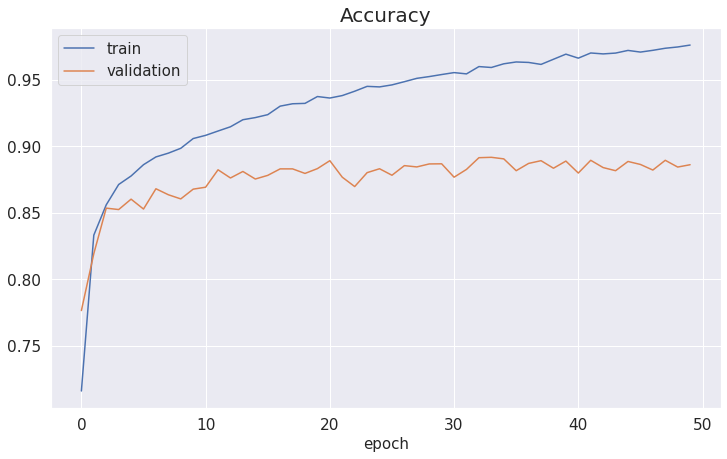

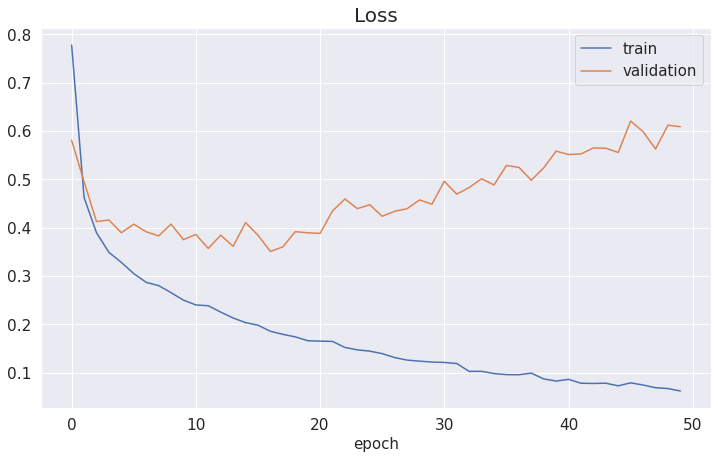

In [ ]:
plot_accuracy_and_loss(train_accuracy, values_accuracy, train_loss, values_loss)

**Conclusion:** Halved the size of the training dataset. I consistently increased the complexity of the models by adding linear layers and activations, each model was trained for 50 epochs, then I compared the loss and metric on the training and test sets. It turned out 3 models: OverfittingNeuralNetworkFirst of 12 layers, 3,793,149 parameters; OverfittingNeuralNetworkSecond of 14 layers, 1,948,563 parameters; OverfittingNeuralNetwork of 10 layers, 1,943,252 parameters. Retraining occurred in each experiment: approximately from the middle of training, we observed an increase in loss on the test set and continued decrease in loss on the training set; increase in accuracy on the training set and fluctuation of accuracy around one value on the test set. At the same time, the more complex the model, the earlier overfitting appeared and the more intensive the growth of the loss on validation went -> the more complex the model, the more it is prone to overfitting.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
class FixedNeuralNetworkWithDropout(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape * 2),
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.Linear(input_shape * 2, int(input_shape / 2)),
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.Linear(int(input_shape / 2), int(input_shape / 4)),
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.Linear(int(input_shape / 4), int(input_shape / 8)),
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.Linear(int(input_shape / 8), int(input_shape / 16)),
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.Linear(int(input_shape / 16), num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(FixedNeuralNetworkWithDropout().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
           Dropout-3                 [-1, 1568]               0
              ReLU-4                 [-1, 1568]               0
            Linear-5                  [-1, 392]         615,048
           Dropout-6                  [-1, 392]               0
              ReLU-7                  [-1, 392]               0
            Linear-8                  [-1, 196]          77,028
           Dropout-9                  [-1, 196]               0
             ReLU-10                  [-1, 196]               0
           Linear-11                   [-1, 98]          19,306
          Dropout-12                   [-1, 98]               0
             ReLU-13                   [-1, 98]               0
           Linear-14                   

In [ ]:
model = FixedNeuralNetworkWithDropout().to(device)
n_epochs = 100
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

In [ ]:
train_accuracy, values_accuracy, train_loss, values_loss = training_loop(model, train_loader, test_loader, loss_func, opt, n_epochs)
print_details_training(train_accuracy, values_accuracy, train_loss, values_loss)

 training loss in first iteration: 1.285531
 validation loss in first iteration: 0.687232
 training accuracy in first iteration: 0.490091
 validation accuracy in first iteration: 0.712695
 training loss in last iteration: 0.189614
 validation loss in last iteration: 0.461272
 training accuracy in last iteration: 0.934201
 validation accuracy in last iteration: 0.889941


Model with Dropout probability of an element to be zeroed p = 0.4 and 17 layers with 1,947,613 trainable parameters:

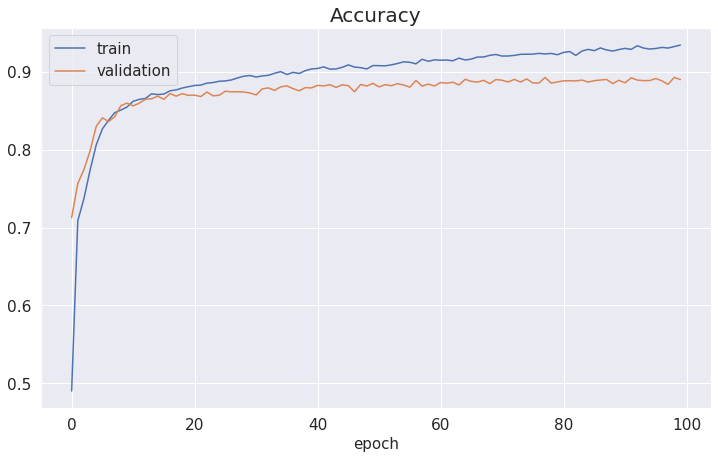

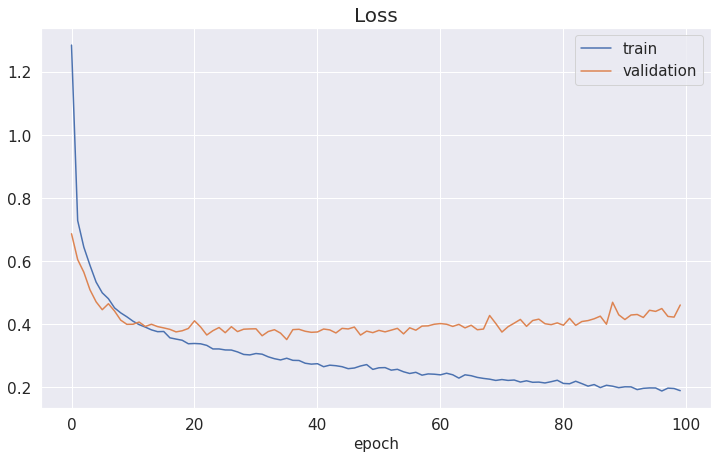

In [ ]:
plot_accuracy_and_loss(train_accuracy, values_accuracy, train_loss, values_loss)

In [ ]:
print_testing_accuracy(model, test_loader)

Test accuracy is:  0.88994140625


In [ ]:
class FixedNeuralNetworkWithBatchNormalization(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape * 2),
            nn.BatchNorm1d(input_shape * 2),
            nn.ReLU(),
            nn.Linear(input_shape * 2, int(input_shape / 2)),
            nn.BatchNorm1d(int(input_shape / 2)),
            nn.ReLU(),
            nn.Linear(int(input_shape / 2), int(input_shape / 4)),
            nn.BatchNorm1d(int(input_shape / 4)),
            nn.ReLU(),
            nn.Linear(int(input_shape / 4), int(input_shape / 8)),
            nn.BatchNorm1d(int(input_shape / 8)),
            nn.ReLU(),
            nn.Linear(int(input_shape / 8), int(input_shape / 16)),
            nn.BatchNorm1d(int(input_shape / 16)),
            nn.ReLU(),
            nn.Linear(int(input_shape / 16), num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(FixedNeuralNetworkWithBatchNormalization().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
       BatchNorm1d-3                 [-1, 1568]           3,136
              ReLU-4                 [-1, 1568]               0
            Linear-5                  [-1, 392]         615,048
       BatchNorm1d-6                  [-1, 392]             784
              ReLU-7                  [-1, 392]               0
            Linear-8                  [-1, 196]          77,028
       BatchNorm1d-9                  [-1, 196]             392
             ReLU-10                  [-1, 196]               0
           Linear-11                   [-1, 98]          19,306
      BatchNorm1d-12                   [-1, 98]             196
             ReLU-13                   [-1, 98]               0
           Linear-14                   

In [ ]:
model = FixedNeuralNetworkWithBatchNormalization().to(device)
n_epochs = 100
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

In [ ]:
train_accuracy, values_accuracy, train_loss, values_loss = training_loop(model, train_loader, test_loader, loss_func, opt, n_epochs)
print_details_training(train_accuracy, values_accuracy, train_loss, values_loss)

 training loss in first iteration: 0.709917
 validation loss in first iteration: 0.491109
 training accuracy in first iteration: 0.817146
 validation accuracy in first iteration: 0.835938
 training loss in last iteration: 0.016833
 validation loss in last iteration: 0.653914
 training accuracy in last iteration: 0.995023
 validation accuracy in last iteration: 0.888477


Model with BatchNormalization and 17 layers with 1,952,219 parameters:

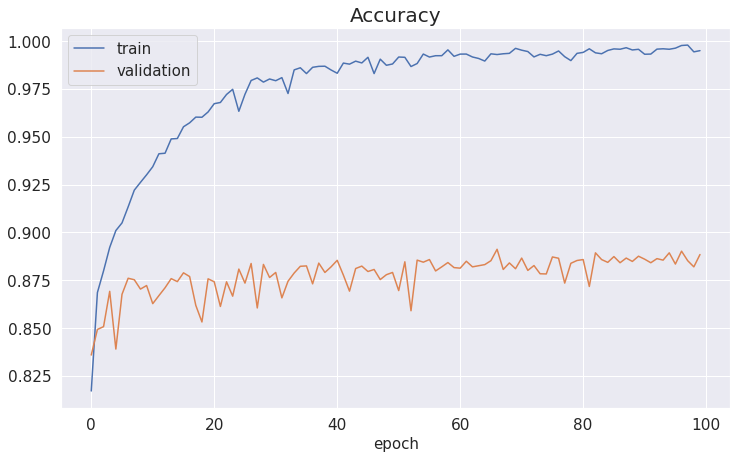

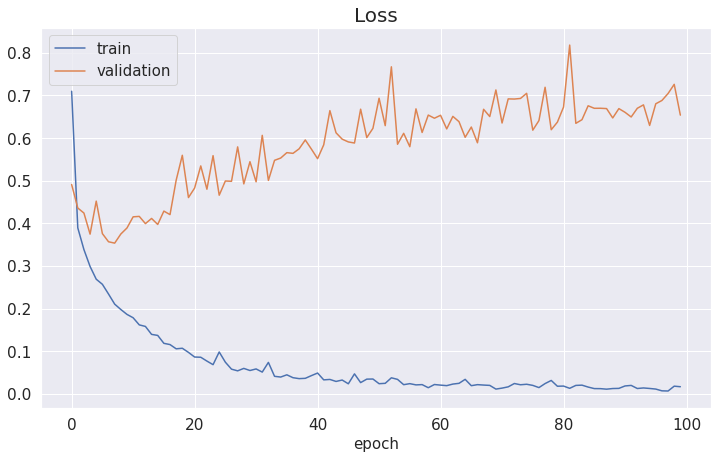

In [ ]:
plot_accuracy_and_loss(train_accuracy, values_accuracy, train_loss, values_loss)

In [ ]:
print_testing_accuracy(model, test_loader)

Test accuracy is:  0.8884765625


**Conclusion:** Already for the reduced training dataset, I applied regularization techniques: Dropout and BatchNormalization, for Dropout I varied the probability parameter of neurons zeroing - the value p=0.4 turned out to be optimal. I trained the resulting models for 100 epochs, the graphs show that the overfitting techniques gave a profit: the loss on the validation set does not start growing, the accuracy value on it is higher than in the overtrained grids and differs less from the accuracy on the training one. It turned out that for such an architecture, Dropout fights overtraining better than BatchNormalization.